In [ ]:
#@title Importing libraries
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Lambda ,Layer
from keras.models import Sequential
import math
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image,ImageOps
from tqdm import tqdm
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from keras import layers, models
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import tensorflow as tf
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense

# Data

# dataset
ATVS-FFp DB
1. The flat optical sensor Biometrika Fx2000 (512 dpi)
2. The sweeping thermal sensor by Yubee with Atmel’s Fingerchip (500 dpi)
3. The flat capacitive sensor by Precise Biometrics model Precise 100 SC (500 dpi).
it can take the vaules "fc", "fo", or "ft", for "capacitive", "optical", or "thermal" depending ono the
sensor used to capture the image

In [ ]:
#@title Connecting to drive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 ATVS-FFp_DB.zip  'Colab Notebooks'   Dataset


In [ ]:
#@title Raw Data Tree Diagram
import os
import zipfile
import matplotlib.pyplot as plt

def extract_zip(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def generate_tree_structure(root_dir):
    tree = {}
    for root, dirs, files in os.walk(root_dir):
        current_level = os.path.relpath(root, root_dir)
        tree.setdefault(current_level, [])
        for dir in dirs:
            tree[current_level].append(dir)
    return tree

def plot_tree_structure(tree, parent=None, indent=0):
    if parent is None:
        for key, value in tree.items():
            print(key)
            plot_tree_structure(tree, key, 1)
    else:
        if isinstance(tree[parent], list):
            for item in tree[parent]:
                print(' ' * indent, '|_', item)
        else:
            for key, value in tree[parent].items():
                print(' ' * indent, '|_', key)
                plot_tree_structure(tree[parent], key, indent + 4)

zip_file = '/content/drive/My Drive/ATVS-FFp_DB.zip'
extracted_folder = '/content/drive/My Drive/Dataset'

# extract_zip(zip_file, extracted_folder)

tree_structure = generate_tree_structure(extracted_folder)

plot_tree_structure(tree_structure)


.
  |_ DS_WithoutCooperation
  |_ DS_WithCooperation
DS_WithoutCooperation
  |_ u01
  |_ u02
  |_ u03
  |_ u04
  |_ u05
  |_ u06
  |_ u07
  |_ u08
  |_ u09
  |_ u10
  |_ u11
  |_ u12
  |_ u13
  |_ u15
  |_ u16
  |_ u17
DS_WithoutCooperation/u01
  |_ fake
  |_ original
DS_WithoutCooperation/u01/fake
DS_WithoutCooperation/u01/original
DS_WithoutCooperation/u02
  |_ fake
  |_ original
DS_WithoutCooperation/u02/fake
DS_WithoutCooperation/u02/original
DS_WithoutCooperation/u03
  |_ fake
  |_ original
DS_WithoutCooperation/u03/fake
DS_WithoutCooperation/u03/original
DS_WithoutCooperation/u04
  |_ fake
  |_ original
DS_WithoutCooperation/u04/fake
DS_WithoutCooperation/u04/original
DS_WithoutCooperation/u05
  |_ fake
  |_ original
DS_WithoutCooperation/u05/fake
DS_WithoutCooperation/u05/original
DS_WithoutCooperation/u06
  |_ fake
  |_ original
DS_WithoutCooperation/u06/fake
DS_WithoutCooperation/u06/original
DS_WithoutCooperation/u07
  |_ fake
  |_ original
DS_WithoutCooperation/u07/fake
DS_W

In [ ]:
#@title Loading Dataset

def load_datasets(folder_path):
    images = []
    labels = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if (file.endswith('.bmp')) and ('fo' in file) :
                img = os.path.join(root, file)
                if 'fake' in root :
                    images.append(img)
                    labels.append(1)
                elif 'original' in root:
                    images.append(img)
                    labels.append(0)
                del img
    pixel_img = []
    for image in tqdm(images):
        img=Image.open(image)
        img=ImageOps.grayscale(img)
        img=np.asarray(img)
        img=img.reshape((img.shape[0], img.shape[1], 1))
        pixel_img.append(img)
    images_main = []
    labels_main = []
    for i  in range(len(pixel_img)):
        if pixel_img[i].shape == (560, 400, 1):
            images_main.append(pixel_img[i])
            labels_main.append(labels[i])
    print(images_main[0].shape)
    pixel_img = np.array(images_main)
    print(pixel_img.shape)
    pixel_img = pixel_img/255

    X_train, X_test, y_train, y_test = train_test_split(pixel_img, labels_main, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    return X_train, X_val, X_test, y_train, y_val, y_test
X_train, X_val, X_test, y_train, y_val, y_test = load_datasets('/content/drive/My Drive/Dataset' )

100%|██████████| 1056/1056 [10:14<00:00,  1.72it/s]


(560, 400, 1)
(688, 560, 400, 1)


In [ ]:
X_train[0].shape

(560, 400, 1)

#Model

In [ ]:
#@title Definition of ISE layer



def powers_of_two(x):
    powers_list = []
    power = 1

    while power <= x:
        powers_list.append(power)
        power *= 2

    return powers_list

import tensorflow as tf



def divide_image(image_tensor, horizontal_sections, vertical_sections):
    height = tf.shape(image_tensor)[1]
    width = tf.shape(image_tensor)[2]

    horizontal_size = width // horizontal_sections
    vertical_size = height // vertical_sections

    divided_images = []
    for i in range(horizontal_sections):
        for j in range(vertical_sections):
            start_x = i * horizontal_size
            end_x = (i + 1) * horizontal_size
            start_y = j * vertical_size
            end_y = (j + 1) * vertical_size

            divided_image = image_tensor[: ,start_y:end_y, start_x:end_x ,:]
            divided_images.append(divided_image)

    return divided_images



class ISE(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(ISE, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):


        input_shape = tf.shape(inputs)
        ph, pw = self.pool_size
        num_segments = powers_of_two(ph)
        split_w = []
        for seg in num_segments:

            for i in divide_image(inputs, seg, seg):
                split_w.append(i)
        max_values = [tf.math.reduce_max(sub_input, axis=(1, 2), keepdims=True) for sub_input in split_w]


        merged = tf.concat(max_values, axis=2)

        return merged

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'pool_size': self.pool_size,
        })
        return config





In [ ]:
#@title Definition of Neural network architecture

def model_arch(n, input_shape=(None, None, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ISE(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

model = model_arch(8)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 32)    320       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 ise (ISE)                   (None, 1, 21, 64)         0         
                                                        

In [ ]:
#@title Training

model.compile(optimizer = 'adam',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)


y_train = np.array(y_train)
y_val = np.array(y_val)

# import os.path
# if os.path.isfile('model.h5') :
#     model = load_model('model.h5')
# else:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
        validation_data=(X_val, y_val), callbacks=[early_stop])
    # model.save('model.h5')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 44s 2s/step - loss: 0.6581 - accuracy: 0.5898 - val_loss: 0.5967 - val_accuracy: 0.5507
Epoch 2/10
13/13 [==============================] - 8s 600ms/step - loss: 0.3603 - accuracy: 0.8762 - val_loss: 0.2482 - val_accuracy: 0.9058
Epoch 3/10
13/13 [==============================] - 8s 601ms/step - loss: 0.2037 - accuracy: 0.9150 - val_loss: 0.0781 - val_accuracy: 0.9710
Epoch 4/10
13/13 [==============================] - 8s 604ms/step - loss: 0.1057 - accuracy: 0.9563 - val_loss: 0.0465 - val_accuracy: 0.9855
Epoch 5/10
13/13 [==============================] - 8s 607ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 8s 617ms/step - loss: 0.0305 - accuracy: 0.9854 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 8s 625ms/step - loss: 0.0288 - accuracy: 0.9903 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 8/10
13/13 [=

In [ ]:
#@title Test

from sklearn.metrics import classification_report

y_pred_proba = model.predict(X_test)
y_pred_proba




y_pred = np.argmax(y_pred_proba, axis=1)
y_pred



print(classification_report(y_test, y_pred))


5/5 [==============================] - 1s 128ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        55

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



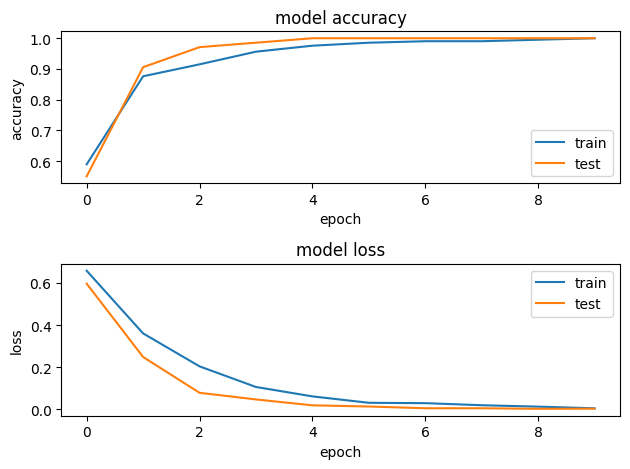

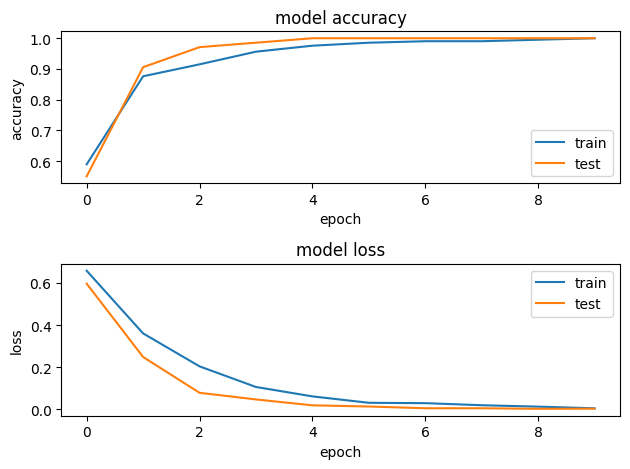

In [ ]:

import os
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig




1/1 [==============================] - 1s 978ms/step
The shape of the conv2d is =======>> (32, 558, 398, 32)
The shape of the conv2d_1 is =======>> (32, 556, 396, 32)
The shape of the max_pooling2d is =======>> (32, 278, 198, 32)
The shape of the conv2d_2 is =======>> (32, 276, 196, 64)
The shape of the conv2d_3 is =======>> (32, 274, 194, 64)
The shape of the ise is =======>> (32, 1, 21, 64)
The shape of the flatten is =======>> (32, 1344)
The shape of the dense is =======>> (32, 128)
The shape of the dense_1 is =======>> (32, 2)


<ipython-input-16-438961627c1b>:26: RuntimeWarning: invalid value encountered in divide
  feature_image/= feature_image.std ()
<ipython-input-16-438961627c1b>:29: RuntimeWarning: invalid value encountered in cast
  feature_image= np.clip(feature_image, 0, 255).astype('uint8')


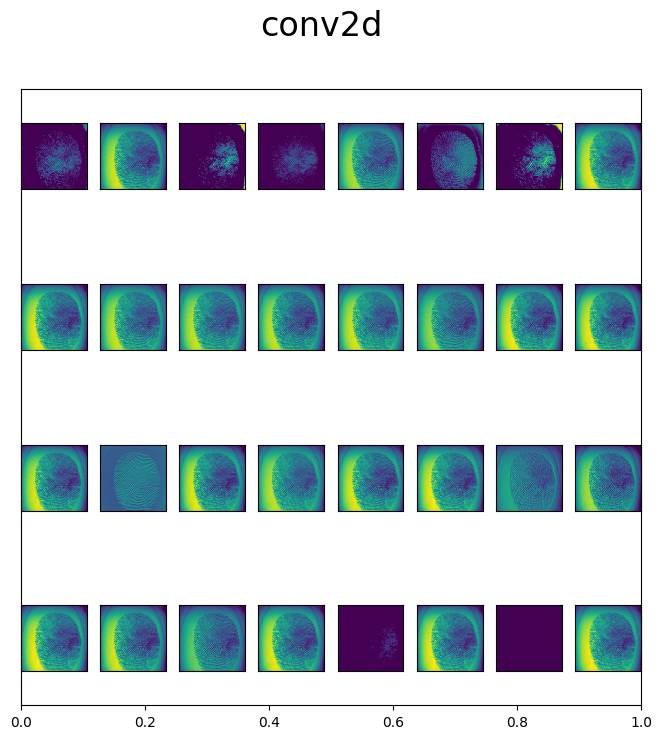

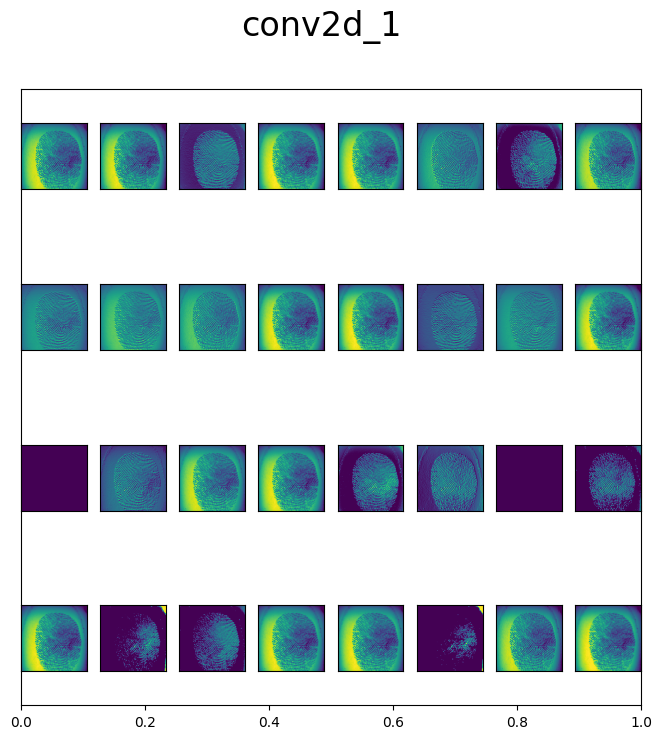

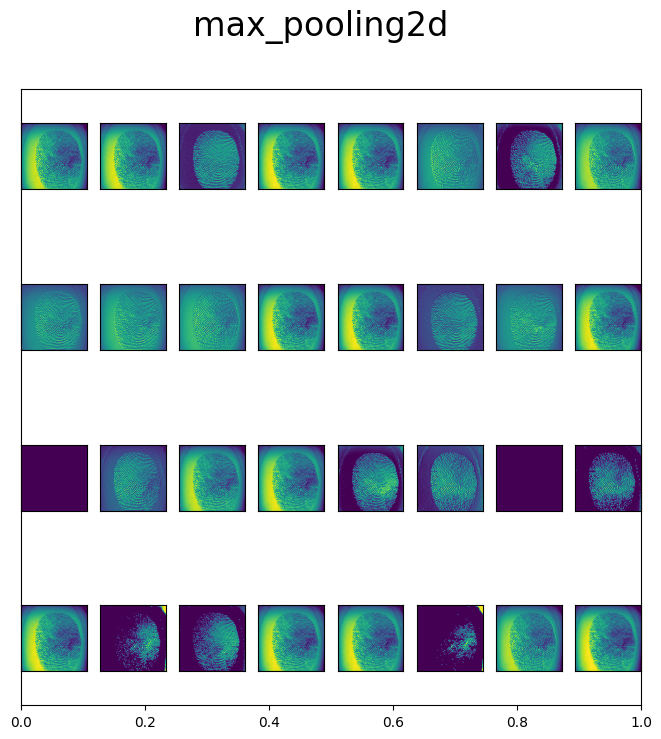

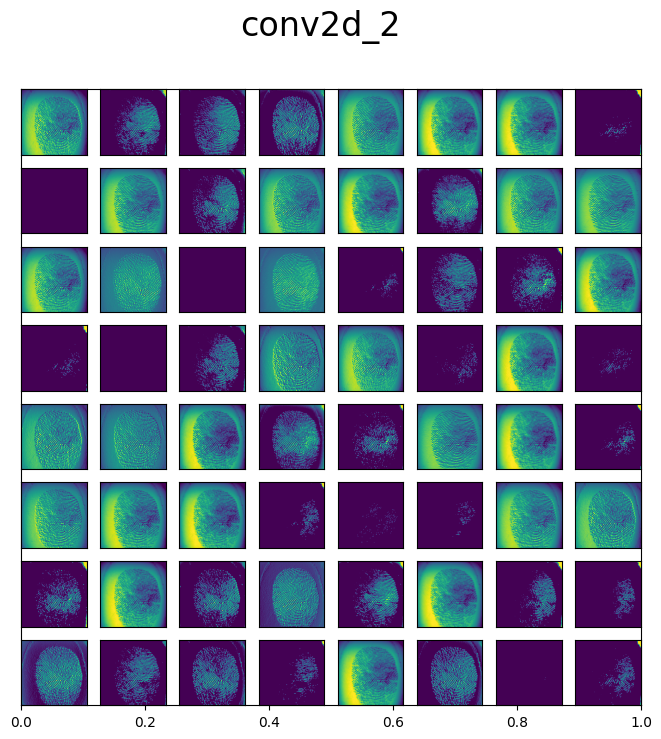

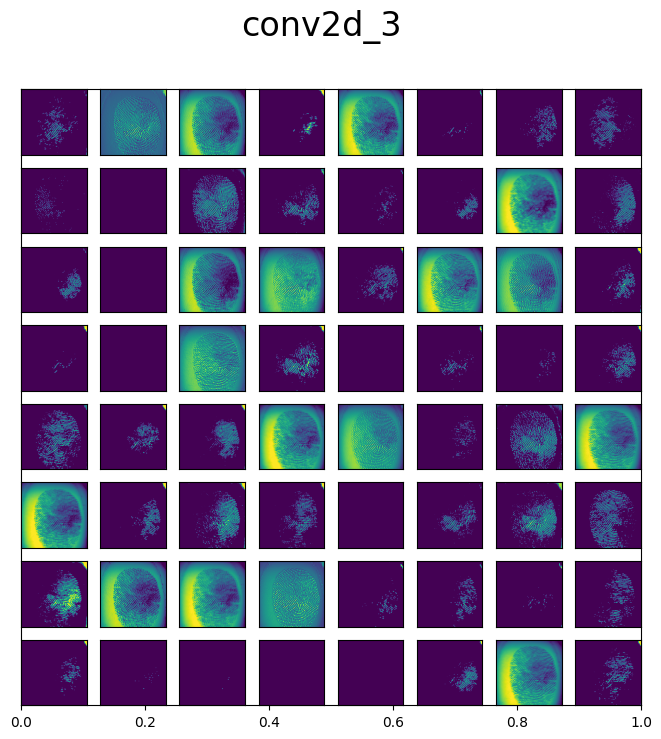

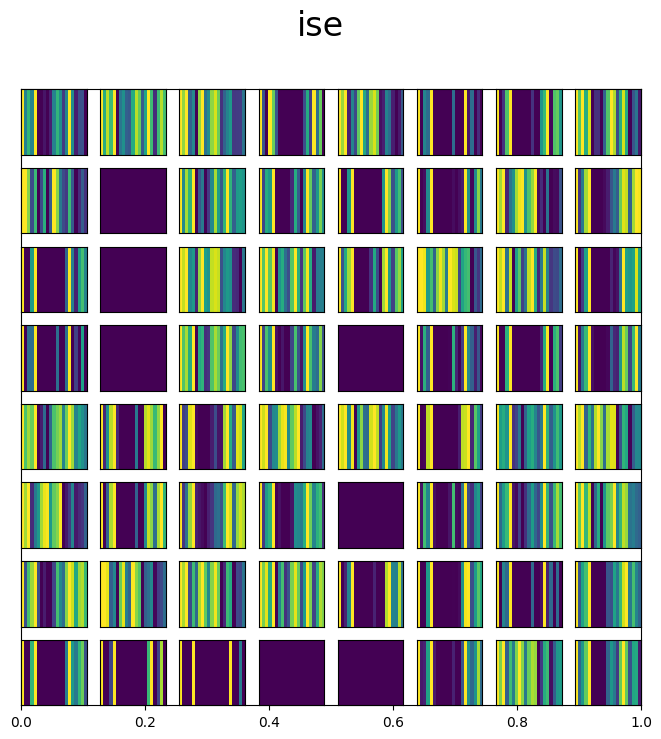

In [ ]:


layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = models.Model(inputs=model.input, outputs=layer_outputs)



feature_maps = feature_map_model.predict(X_test[0:32])


for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4 :
        k = feature_map.shape[-1]
        size=feature_map.shape[1]
        fig = plt.figure(figsize=(8,8))
        fig.suptitle(layer_name ,fontsize = 24)
        plt.grid  ( False )
        plt.gca().axes.get_yaxis().set_visible(False)
        for i in range(k):
            feature_image = feature_map[0, :, :, i]


            feature_image-= feature_image.mean()
            feature_image/= feature_image.std ()
            feature_image*=  64
            feature_image+= 128
            feature_image= np.clip(feature_image, 0, 255).astype('uint8')
            # image_belt = feature_image[:, i * size : (i + 1) * size]

            scale = 20. / k
            # plt.figure( figsize=(scale*10 , scale*10*k) )

            ax = fig.add_subplot(int(k/8),8,i+1)
            ax.set_box_aspect(1)
            ax.imshow( feature_image, aspect='auto')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
